In [2]:
!pip install pennylane

In [3]:
import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys

# Setting our constants
sys.path.append('..')

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [4]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy

--2026-01-06 07:02:54--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘train_X.npy’

train_X.npy         100%[===================>]  32.12K  --.-KB/s    in 0.002s  

2026-01-06 07:02:54 (13.2 MB/s) - ‘train_X.npy’ saved [32896/32896]

--2026-01-06 07:02:54--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256 [

In [5]:
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [9]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

t_train_X, t_train_y = data_to_tensor(train_X, train_y)
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [52]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np

# [설정]
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)
device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# [수정 1] 검증된 강력한 회로 템플릿 사용
# ==========================================
@qml.qnode(dev, interface='torch')
def circuit(state, weights):
    # 1. 데이터 입력 (Amplitude Embedding: 256개 픽셀 -> 8 큐비트 상태)
    # 데이터 전처리가 잘 되어있다는 가정하에 전체 데이터를 넣습니다.
    # 만약 앞서 구한 '중요 픽셀'만 쓰고 싶다면 여기서 처리가 필요하지만,
    # Baseline을 이기려면 일단 전체 정보를 효율적으로 섞는게 우선입니다.
    qml.StatePrep(state, wires=range(n_qubits))

    # 2. 강력한 얽힘 레이어 (Strongly Entangling Layers)
    # 직접 구현한 Rot+CNOT보다 훨씬 복잡하게 얽혀서 적은 층으로도 효과가 좋습니다.
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # 3. 측정 (0, 1번 큐비트 사용)
    return qml.probs(wires=[0, 1])

class QNN(nn.Module):
    def __init__(self):
        super().__init__()
        # [수정 2] 레이어 수 최적화 (15층 -> 3층)
        # 데이터가 적을 때는 층이 얇아야 학습이 잘 됩니다 (Barren Plateau 회피).
        self.n_layers = 3

        # StronglyEntanglingLayers의 가중치 shape: (n_layers, n_qubits, 3)
        self.weight_shape = (self.n_layers, n_qubits, 3)
        self.total_params = self.n_layers * n_qubits * 3

        torch.manual_seed(42)
        # 가중치 초기화
        self.params = nn.Parameter(torch.randn(self.weight_shape, requires_grad=True) * 0.1)

    def forward(self, x):
        return circuit(x, self.params)

# ==========================================
# 학습 설정
# ==========================================
model = QNN()
model.to(device)

# 학습률을 약간 높여서(0.1) 초반에 빠르게 찾고, 스케줄러로 줄입니다.
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=0.001)

print(f"--- Training QNN (New Arch, Layers: {model.n_layers}) ---")

# Loss 함수 (그대로 유지)
def quantum_phase_loss(probs, labels):
    probs = probs + 1e-8
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1])
    probs = probs / torch.sum(probs, dim=1, keepdim=True)
    loss = -torch.sum(label_one_hot * torch.log(probs), dim=1)
    return torch.mean(loss)

# 데이터 로더가 있다고 가정하고 실행
if 'train_loader' in globals():
    for epoch in range(200):
        total_loss = 0
        correct = 0

        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = quantum_phase_loss(predictions, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted_classes = torch.argmax(predictions, dim=1)
            correct += (predicted_classes == batch_y).sum().item()

        scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_acc = correct / len(train_dataset) # train_dataset 접근 가능 가정

        if (epoch + 1) % 20 == 0:
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f} | LR: {lr:.5f}")
else:
    print("Error: 'train_loader'와 'train_dataset'이 메모리에 없습니다. 이전 코드를 먼저 실행해주세요.")

--- Training QNN (New Arch, Layers: 3) ---
Epoch 20 | Loss: 0.6494 | Acc: 0.6875 | LR: 0.09758
Epoch 40 | Loss: 0.6402 | Acc: 0.8125 | LR: 0.09055
Epoch 60 | Loss: 0.6028 | Acc: 0.9375 | LR: 0.07960
Epoch 80 | Loss: 0.5870 | Acc: 1.0000 | LR: 0.06580
Epoch 100 | Loss: 0.5930 | Acc: 1.0000 | LR: 0.05050
Epoch 120 | Loss: 0.5857 | Acc: 1.0000 | LR: 0.03520
Epoch 140 | Loss: 0.5814 | Acc: 1.0000 | LR: 0.02140
Epoch 160 | Loss: 0.5813 | Acc: 1.0000 | LR: 0.01045
Epoch 180 | Loss: 0.5805 | Acc: 1.0000 | LR: 0.00342
Epoch 200 | Loss: 0.5804 | Acc: 1.0000 | LR: 0.00100


--- 🔍 Unfolding the Quantum Circuit (StronglyEntanglingLayers) ---


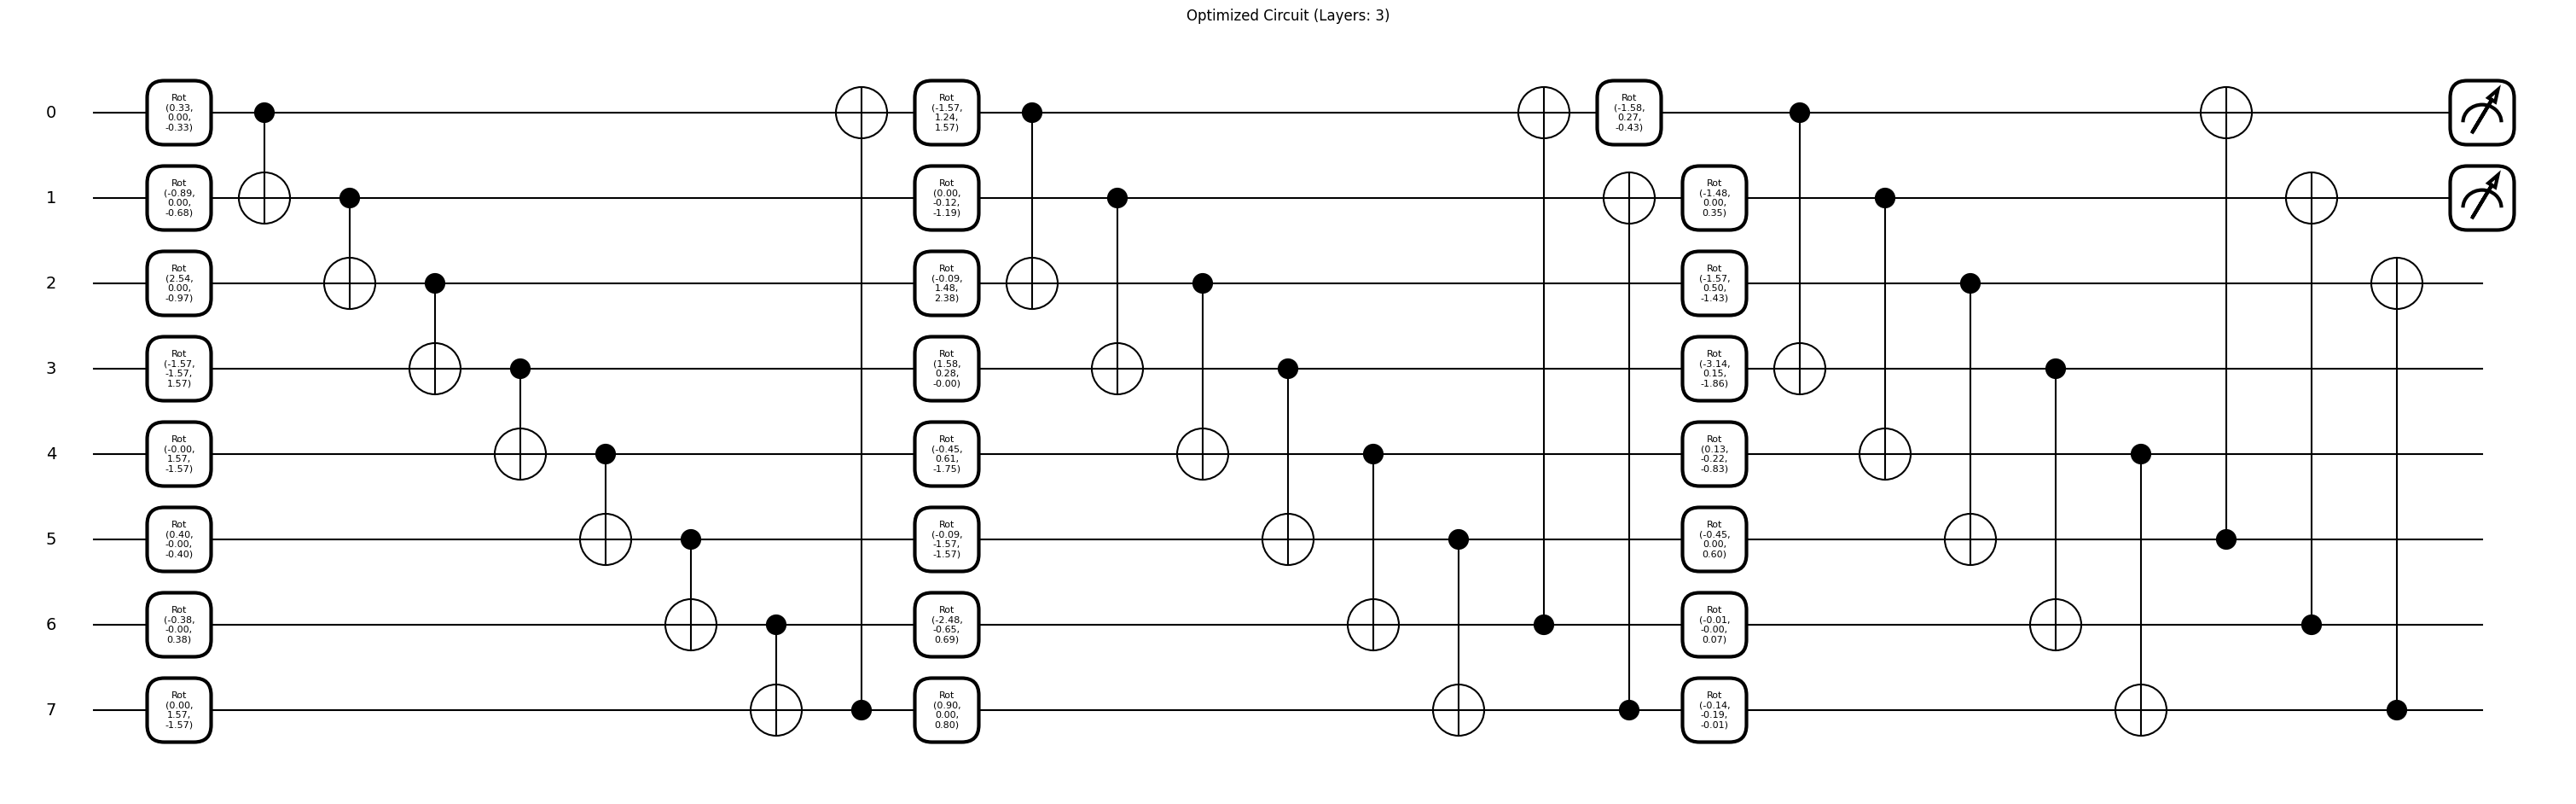

In [53]:
import matplotlib.pyplot as plt
import pennylane as qml

# =========================================================
# 1. 모델 구조만 보여주는 전용 함수 정의
# =========================================================
@qml.qnode(dev, interface="torch")
def visualize_ansatz_only(params):
    # [업데이트] 이전의 Quantum_classifier 대신
    # 강력한 얽힘 레이어(StronglyEntanglingLayers)를 사용합니다.
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))

    # [업데이트] 측정 위치가 [0, 1]로 변경되었습니다.
    return qml.probs(wires=[0, 1])

# =========================================================
# 2. 그리기
# =========================================================
print("--- 🔍 Unfolding the Quantum Circuit (StronglyEntanglingLayers) ---")

# level=2 옵션으로 템플릿 내부의 회전 게이트와 CNOT들을 풀어헤쳐서 보여줍니다.
fig, ax = qml.draw_mpl(visualize_ansatz_only, level=2, decimals=2)(model.params)

plt.title(f"Optimized Circuit (Layers: {model.n_layers})")
plt.show()

In [54]:
import json

# [업데이트] 측정할 큐비트 인덱스 (학습 코드와 동일하게 0, 1번)
measurements = [0, 1]

# 1. 학습된 파라미터 추출 (Tensor -> Numpy 변환)
# model.params가 이제 (3, 8, 3) 형태를 가집니다.
params = model.params.detach().cpu().numpy()

# 2. QASM 변환을 위한 회로 정의
# (StatePrep을 제외하고, 학습된 회로 부분만 정의합니다)
@qml.qnode(dev, interface='torch')
def Classifier(params):
    # [업데이트] 학습 코드와 동일한 레이어 사용
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))

# 3. OpenQASM 문자열 생성
# measure_all=False로 해야 우리가 원하는 부분만 나옵니다.
qasm_data = qml.to_openqasm(Classifier, measure_all=False)(params)

print(f"✅ Measurement Qubits: {measurements}")
print(f"✅ QASM Data Generated (Length: {len(qasm_data)} characters)")
print("--- QASM Preview (First 10 lines) ---")
print("\n".join(qasm_data.split('\n')[:10]))

# 4. JSON 파일 저장
# 파일명을 구분하기 위해 'submission_improved.json'으로 변경했습니다.
file_name = "./submission_improved.json"
with open(file_name, "w") as f:
    json.dump({
        "qasm": qasm_data,
        "measurements": measurements
    }, f)

print(f"✅ Submission file '{file_name}' created successfully.")

✅ Measurement Qubits: [0, 1]
✅ QASM Data Generated (Length: 1944 characters)
--- QASM Preview (First 10 lines) ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
rz(0.32635126) q[0];
ry(3.8577306e-05) q[0];
rz(-0.3263492) q[0];
rz(-0.89287156) q[1];
ry(0.00030190533) q[1];
rz(-0.6779266) q[1];
✅ Submission file './submission_improved.json' created successfully.


In [58]:
from google.colab import files
files.download(f'{file_name}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>